In [ ]:
!pip install transformers pandas openpyxl scikit-learn matplotlib seaborn

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving break_freeze.xlsx to break_freeze (1).xlsx


In [ ]:

import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
model.eval()

# 엑셀 파일 로드
filename = [f for f in uploaded if f.endswith(".xlsx")][0]
df = pd.read_excel(filename)

sentences = df.iloc[:, 4]  # E열: 문장
syntaxes = df.iloc[:, 5]   # F열: 구문
labels = df.iloc[:, 7]     # H열: 의미

keywords = ['break', 'broke', 'broken', 'breaking', 'freez', 'froze', 'frozen', 'freezing']

def extract_token_embedding(sentence, keywords):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    match_indices = [i for i, t in enumerate(tokens) if any(kw in t for kw in keywords)]
    if not match_indices:
        return [None] * 768
    return outputs.last_hidden_state[0][match_indices[0]].numpy().tolist()

embeddings, valid_labels, valid_syntaxes, valid_sentences = [], [], [], []

for sent, syn, label in tqdm(zip(sentences, syntaxes, labels), total=len(sentences)):
    vec = extract_token_embedding(str(sent), keywords)
    if vec[0] is not None:
        embeddings.append(vec)
        valid_labels.append(label)
        valid_syntaxes.append(syn)
        valid_sentences.append(sent)

# 저장
embedding_df = pd.DataFrame(embeddings)
embedding_df['sense'] = valid_labels
embedding_df['syntax'] = valid_syntaxes
embedding_df['sentence'] = valid_sentences
embedding_df.to_csv("bert_embeddings_with_syntax.csv", index=False)

from google.colab import files
files.download("bert_embeddings_with_syntax.csv")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 1002/1002 [03:04<00:00,  5.42it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 📦 필요 라이브러리 설치
!pip install pandas openpyxl seaborn matplotlib scikit-learn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
# 📁 파일 업로드
from google.colab import files
uploaded = files.upload()

Saving bert_embeddings_with_syntax.csv to bert_embeddings_with_syntax (1).csv


In [ ]:
# 📄 데이터 로드 (sense + syntax + sentence 포함된 CSV)
filename = list(uploaded.keys())[0]
# Try reading with 'utf-8' encoding first
try:
    df = pd.read_csv(filename, encoding='utf-8')
except UnicodeDecodeError:
    # If 'utf-8' fails, try 'cp949' or 'latin-1'
    try:
        df = pd.read_csv(filename, encoding='cp949')
    except UnicodeDecodeError:
        df = pd.read_csv(filename, encoding='latin-1')
# Specify 'euc-kr' encoding

In [ ]:
# 🧠 전처리: 동사 태깅 (break vs freeze)
df["verb"] = df["sense"].apply(lambda x: "break" if "break" in str(x).lower() else (
                                          "freeze" if "freez" in str(x).lower() else "unknown"))

In [ ]:
### 추가 (verb - sense 수동 mapping) ###

# Step 1: sense-to-verb 딕셔너리 정의
sense_to_verb = {
    # break 관련 senses
    'EPS_other': 'break',
    'Stopping_end': 'break',
    'Physical breaking': 'break',
    'Bodily injury': 'break',
    'Stopping_interrupt': 'break',
    'Breaking barriers/limits': 'break',
    'Violation': 'break',
    'Natural emergence': 'break',
    'Breaking barriers_disclose': 'break',
    'EPS_betray': 'break',
    'Stopping_discard': 'break',
    'EPS_lose control': 'break',

    # freeze 관련 senses
    'Economical/financial freezing': 'freeze',
    'Halt in progress': 'freeze',
    'Natural freezing': 'freeze',
    'Emotional freezing': 'freeze',
    'Physical/bodily immobility': 'freeze',
    'Physical freezing': 'freeze',
    'Preservation': 'freeze',
    'Bodily freezing': 'freeze',
    'Mechanical breakdown': 'freeze',
    'Tech failure': 'freeze',
    'Social freezing': 'freeze',
}

# Step 2: verb 컬럼 생성
df['verb'] = df['sense'].map(sense_to_verb).fillna('unknown')

In [ ]:
print(df)

             0         1         2         3         4         5         6  \
0    -0.431813  0.517353 -0.052716  0.329312  0.733251  0.096814  0.196596   
1     0.344663  0.699486  0.156842  0.859550  1.000646  0.153324  0.517201   
2    -0.472530  0.401741 -0.045166  0.107536  0.005376  0.393608  0.627388   
3     0.219835  0.346359 -0.550896  0.409253  0.994255 -0.536137  0.073117   
4     0.399038  0.215541  0.439347  0.288652  1.460976 -0.640918  0.484487   
...        ...       ...       ...       ...       ...       ...       ...   
997   0.456746  0.017476  0.614039  0.327843  0.354082  0.159294  0.205561   
998   0.759600  0.166569  0.288335  0.212422  1.088400  0.094660  0.476108   
999   0.968606  0.882645 -0.076489 -0.195994 -0.038849 -0.172950  0.069940   
1000  1.087639  0.327397  0.624524  0.081621  0.547900  0.134391  0.449261   
1001  0.080907  0.769553 -0.106087  0.072690 -0.025398 -0.181115  0.234857   

             7         8         9  ...       762       763    

In [ ]:
# 🎯 분석 대상 동사 리스트
verbs_to_analyze = ['break', 'freeze']


🔍 Analyzing verb: break
Explained Variance Ratio:
[0.07860843 0.05685806]


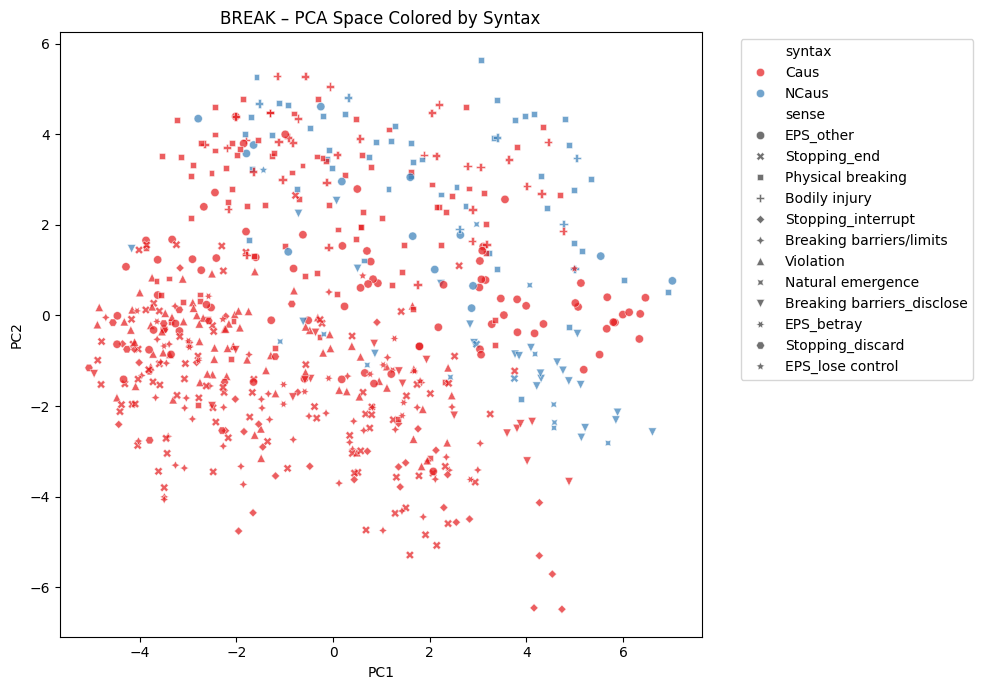

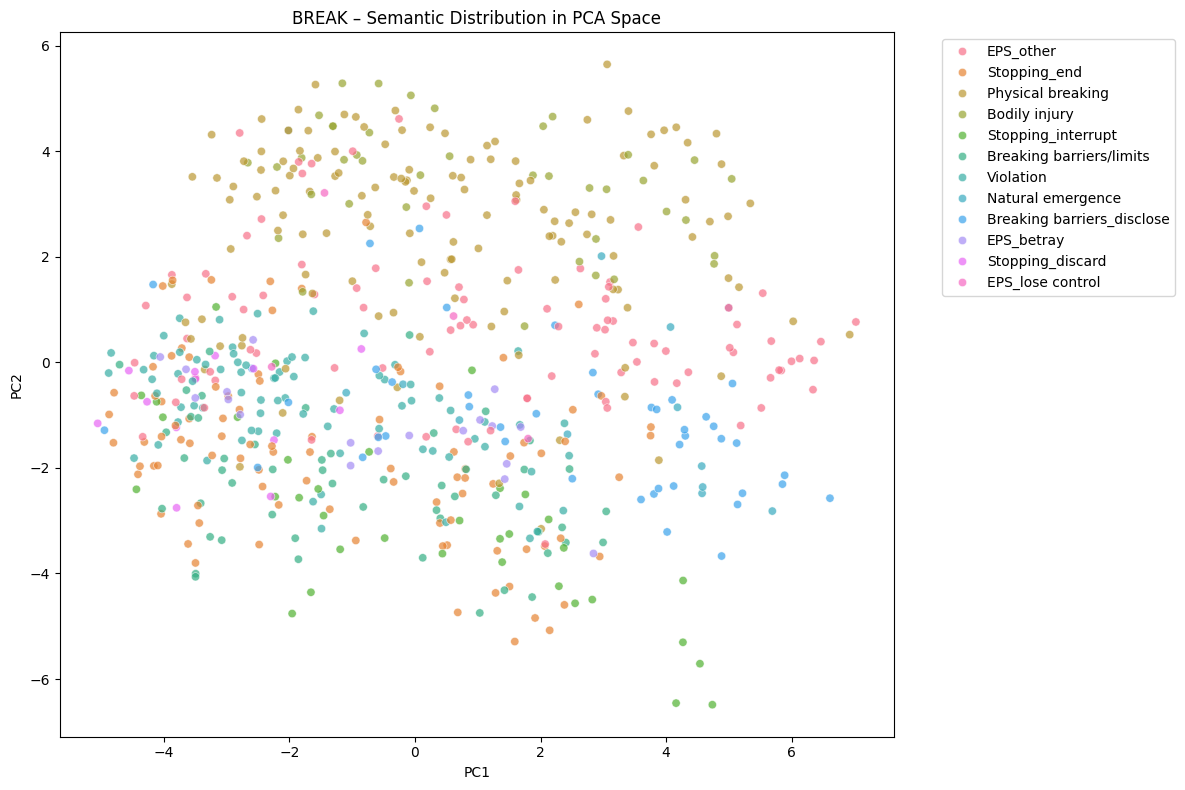


🔍 Analyzing verb: freeze
Explained Variance Ratio:
[0.20285539 0.06704273]


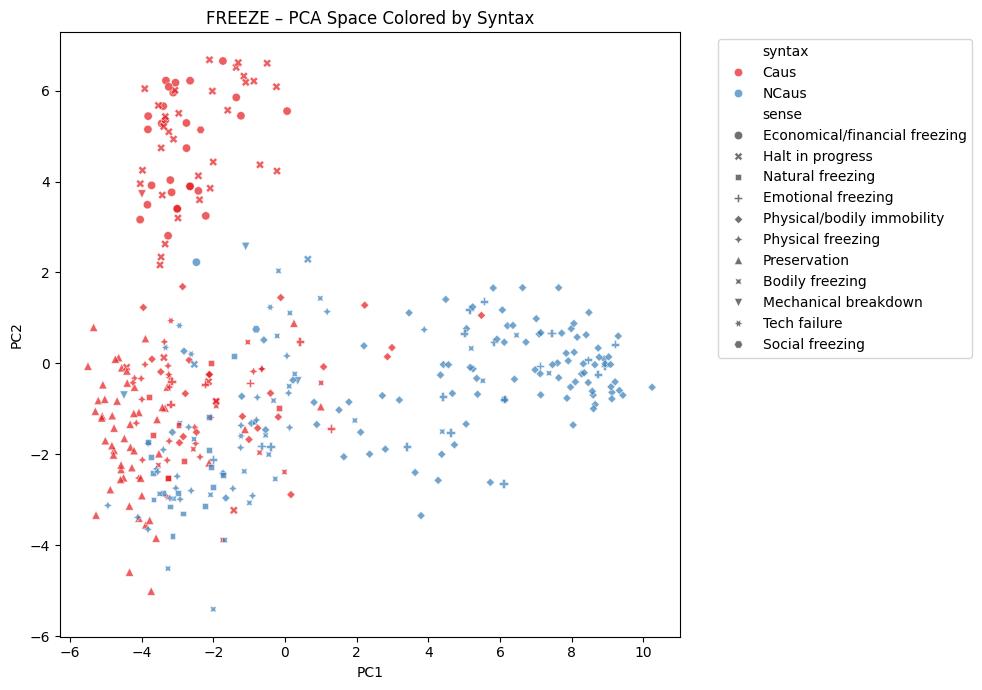

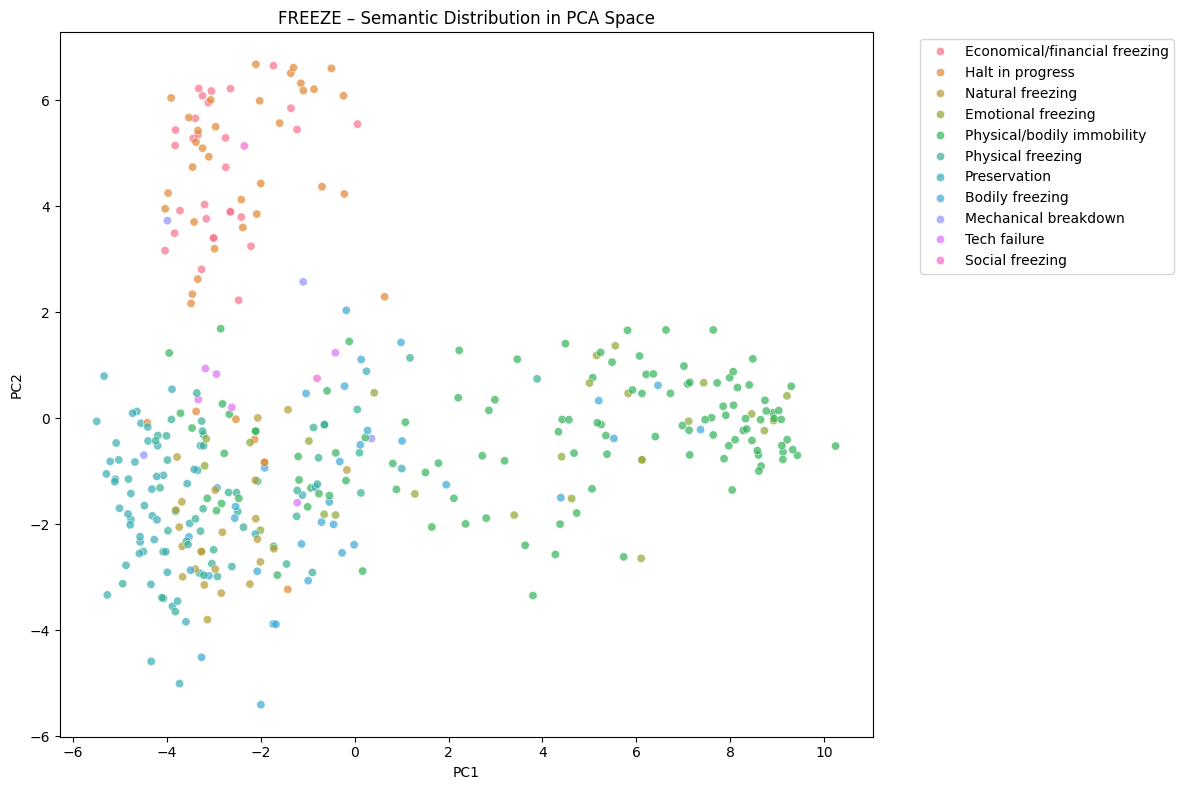

In [ ]:
# 🔁 동사별 PCA 수행
for verb in verbs_to_analyze:
    print(f"\n🔍 Analyzing verb: {verb}")
    sub_df = df[df['verb'] == verb].copy()

    # 임베딩만 추출
    X = sub_df.iloc[:, :768]

    # PCA 수행
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)
    sub_df["PC1"], sub_df["PC2"] = components[:, 0], components[:, 1]

    # 설명력 출력
    print("Explained Variance Ratio:")
    print(pca.explained_variance_ratio_)

    # 구문 분포 시각화
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=sub_df, x="PC1", y="PC2", hue="syntax", style="sense", palette="Set1", alpha=0.7)
    plt.title(f"{verb.upper()} – PCA Space Colored by Syntax")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 의미군 분포 시각화
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=sub_df, x="PC1", y="PC2", hue="sense", alpha=0.7)
    plt.title(f"{verb.upper()} – Semantic Distribution in PCA Space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()